In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Database location
Download first the database from  https://drive.google.com/file/d/1IuZlyNjg6DMQE3iaO1Px6h1yLKgatynt

and unzip. You can use !unzip "RNN-HAR-2D-Pose-database.zip" 

In [ ]:
cd /content/drive/MyDrive/'Colab Notebooks'/RNN

/content/drive/MyDrive/Colab Notebooks/RNN


In [ ]:
!ls

 char_rnn_classification_tutorial.ipynb
 confunsion_Matrix.ipynb
'Copia de LSTMs in PyTorch 🔥'
'Human Action Recognition with LSTM Using PyTorch - RNN-HAR-2D-Pose-database.ipynb'
 RNN-HAR-2D-Pose-database
 save_model
 sequence_models_tutorial.ipynb
'Time Series Prediction with LSTM Using PyTorch'
'Tutorial 4 rnn - exercise.ipynb'



## Information ressources

https://github.com/stuarteiffert/RNN-for-Human-Activity-Recognition-using-2D-Pose-Input

https://learnopencv.com/human-action-recognition-using-detectron2-and-lstm/

https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition

https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb

CNN version
https://github.com/nestiank/action-recognition-cnn-bd-lstm/tree/506ad621746af393257cdf0c533faf2526d3edbe

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

import numpy as np
import random
import time
import os

import torch
import torch.nn as nn
from torch.autograd import Variable

## Monitoring the results

In [ ]:
def plot(epoch, train_loss, val_loss, acc):
    clear_output(True)
    fig = plt.figure()
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.plot(train_loss, label='Train_loss')
    plt.plot(val_loss, label='Val_loss')
    plt.legend(loc="best")
    plt.subplot(132)
    plt.plot(acc, label='acc')
    plt.legend(loc="best")
    plt.show()

## Read from the database

In [ ]:
# Load the networks inputs
def load_X(X_path, n_steps):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    blocks = int(len(X_) / n_steps)
    
    X_ = np.array(np.split(X_,blocks))

    return X_ 

# Load the networks outputs
def load_y(y_path, n_steps):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # for 0-based indexing 
    return y_ - 1

## Mini-bach sampling

In [ ]:
def extract_batch_size(_train, _labels, _unsampled, batch_size):
    # Fetch a "batch_size" amount of data and labels from "(X|y)_train" data. 
    # Elements of each batch are chosen randomly, without replacement, 
    # from X_train with corresponding label from Y_train
    # unsampled_indices keeps track of sampled data ensuring non-replacement. 
    # Resets when remaining datapoints < batch_size    
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    batch_labels = np.empty((batch_size,1)) 

    for i in range(batch_size):
        # Loop index
        # index = random sample from _unsampled (indices)
        #index = random.choice(_unsampled)
        index = np.random.choice(_unsampled, 1, replace=False)
        #print ("len", len(_unsampled), "index", index)
        batch_s[i] = _train[index] 
        batch_labels[i] = _labels[index]
        _unsampled = np.setdiff1d(_unsampled, index)
        #_unsampled.remove(index)
        #_unsampled = np.delete(_unsampled, index)
    return batch_s, batch_labels, _unsampled

def one_hot(y_):
    # One hot encoding of the network outputs
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

## Model

In [ ]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sm = torch.nn.Softmax(dim=1)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))       
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        out = self.sm (out)
  
        return out

## Trainning

In [ ]:
# Useful Constants

DATASET_PATH = "RNN-HAR-2D-Pose-database/"

X_train_path = DATASET_PATH + "X_train.txt"
X_val_path = DATASET_PATH + "X_test.txt"

y_train_path = DATASET_PATH + "Y_train.txt"
y_val_path = DATASET_PATH + "Y_test.txt"

n_steps = 32 # 32 frames per series

X_train = load_X(X_train_path, n_steps)
X_val = load_X(X_val_path, n_steps)

y_train = load_y(y_train_path, n_steps)
y_val = load_y(y_val_path, n_steps)

print ('Training_data_count =', len(X_train))
print ('Val_data_count =', len(X_val))
print ('N_steps =', len(X_train[0]))
print ('N_input =', len(X_train[0][0]))

Training_data_count = 22625
Val_data_count = 5751
N_steps = 32
N_input = 36


In [ ]:
# Optimization
batch_size = 4096

<Figure size 432x288 with 0 Axes>

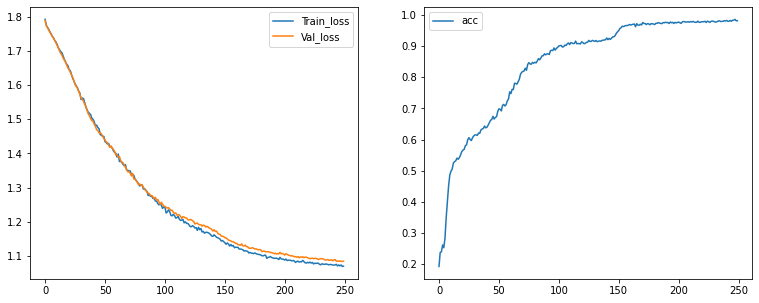

Best result : 0.98130, at epoch : 2470
Running mean accuracy  : 0.98137


In [ ]:
#time_start = time.time()
unsampled_indices = range(0,len(X_train))
unsampled_indices_val = range(0,len(X_val))

# Monitoring
val_interval = 10
plot_interval = 10

best_epoch = 0
best_result = -np.Inf

save_path = './save_model/'

train_losses = []
val_losses = []
accuracies = []

## Hyperparameters
num_epochs = 2500

# Optimization
batch_size = 4096
learning_rate = 0.0002

# NN model
input_size = 36
hidden_size = 128
num_layers = 1
num_classes = 6

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
criterion = torch.nn.CrossEntropyLoss()    # cross entropy loss
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 
            factor=0.5, patience=10, min_lr=1e-15, verbose=True)
# Decay LR by a factor of 0.1 every 7 epochs
#scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

lstm.train()

for epoch in range(num_epochs):
  if len(unsampled_indices) < batch_size:
    unsampled_indices = range(0,len(X_train)) 
  batch_xs, raw_labels, unsampled_indicies = extract_batch_size(X_train, y_train, unsampled_indices, batch_size)
  batch_ys = one_hot(raw_labels)

  batch_xs = Variable(torch.Tensor(batch_xs))
  batch_ys = Variable(torch.Tensor(batch_ys))

  y_pred = lstm(batch_xs)
  
  # Obtain the loss function
  loss = criterion(y_pred, batch_ys)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  running_corrects = 0

  # Validate training
  if epoch % val_interval == 0:
    # Network in evaluation mode
    lstm.eval()
    with torch.no_grad():
      if len(unsampled_indices_val) < batch_size:
        unsampled_indices_val = range(0,len(X_val)) 
      batch_xs, raw_labels, unsampled_indices_val = extract_batch_size(X_val, y_val, unsampled_indices_val, batch_size)
      batch_ys = one_hot(raw_labels)

      batch_xs = Variable(torch.Tensor(batch_xs))
      batch_ys = Variable(torch.Tensor(batch_ys))

      y_pred = lstm(batch_xs)
      pred = y_pred.max(1, keepdim=True)[1] # get the index of the max logit

      raw_labels = Variable(torch.Tensor(raw_labels))
      acc = torch.sum(pred == raw_labels)/batch_size

      accuracies.append(acc.item())

      val_loss = criterion(y_pred, batch_ys)
      scheduler.step(val_loss) # Note that step should be called after validate()

      val_losses.append(val_loss.item())
      lstm.train()
      train_losses = np.append(train_losses,loss.item())

  # Plot for monitoring
  if epoch % plot_interval == 0:
    plot(epoch, train_losses, val_losses, accuracies)
    #print("Epoch: %d, train loss: %1.5f, val loss: %1.5f and accurary"  % (epoch, loss.item(), np.mean(val_losses[-10:]), acc.item()))
    print("Best result : %1.5f, at epoch : %d" % (best_result, best_epoch))
    print("Running mean accuracy  : %1.5f" % (np.mean(accuracies[-10:])))
    
  # Save the best model
  if np.mean(accuracies[-10:]) > best_result:
    best_result = np.mean(accuracies[-10:])
    best_epoch = epoch
    if not os.path.isdir(save_path):
      os.makedirs(save_path)
    ckpt_path = save_path +'/'+ 'model_epoch_'+str(best_epoch)+'acc'+str(np.mean(accuracies[-10:]))+'.pth.tar'
    torch.save(lstm.state_dict(), ckpt_path)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

In [ ]:
# NN model
input_size = 36
hidden_size = 128
num_layers = 1
num_classes = 6

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

save_path = './save_model/'
ckpt_path = save_path +'/'+ 'model_3.pth.tar'

lstm.load_state_dict(torch.load(ckpt_path))
lstm.eval()

y_pred = []
y_true = []

unsampled_indices_val = range(0,len(X_val)) 
print (unsampled_indices_val)
init_len = len(unsampled_indices_val)

batch_size = init_len

# iterate over test data
while (1):
  batch_xs, raw_labels, unsampled_indices_val = extract_batch_size(X_val, y_val, unsampled_indices_val, batch_size)

  batch_xs = Variable(torch.Tensor(batch_xs))
  pred = Variable(torch.Tensor(raw_labels))

  pred = lstm(batch_xs)

  #output = (torch.max(torch.exp(pred), 1)[1]).data.cpu().numpy()
  output = pred.max(1, keepdim=True)[1].data.cpu().numpy()

  #y_pred.append(output) # Save Prediction

  #labels = labels.data.cpu().numpy()
  #y_true.append(raw_labels) # Save Truth

  print (len(unsampled_indices_val)*100/init_len)
  if len(unsampled_indices_val) < batch_size:
    break

range(0, 5751)
0.0


[[97.2  0.   0.   0.1  0.2  0.9]
 [ 0.  99.2  0.2  0.8  0.   0. ]
 [ 1.2  0.  97.   0.   0.   5.9]
 [ 0.6  0.6  0.  98.9  0.   0. ]
 [ 0.6  0.1  0.2  0.  99.8  0.7]
 [ 0.4  0.   2.7  0.2  0.  92.4]]


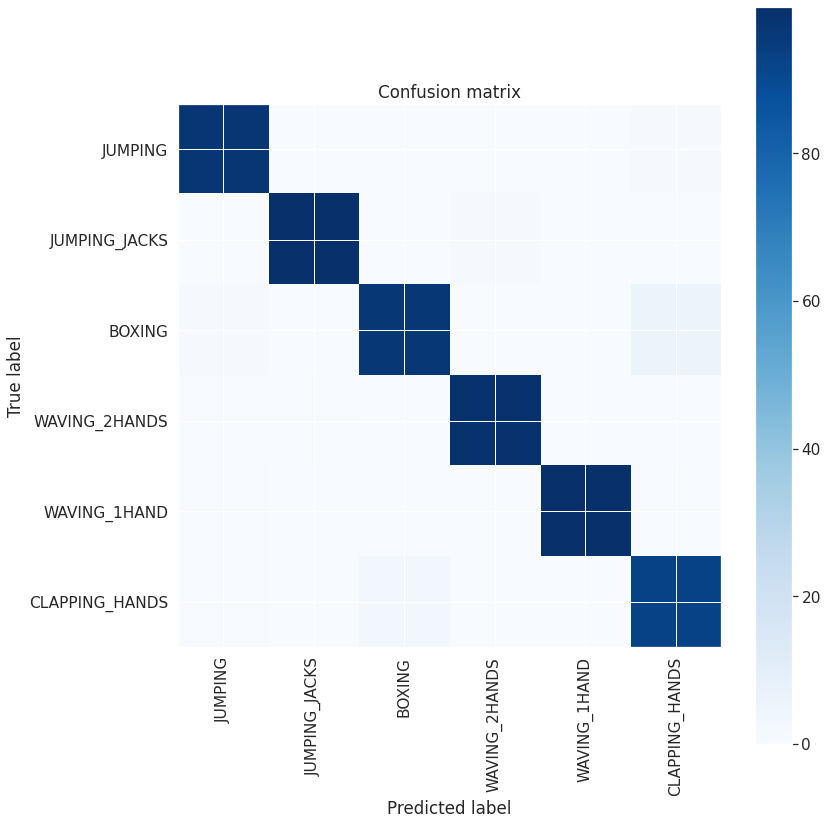

<function matplotlib.pyplot.close>

<Figure size 432x288 with 0 Axes>

In [ ]:
# Output classes to learn how to classify
LABELS = [    
    "JUMPING",
    "JUMPING_JACKS",
    "BOXING",
    "WAVING_2HANDS",
    "WAVING_1HAND",
    "CLAPPING_HANDS"]

# Build confusion matrix
cf_matrix = confusion_matrix(raw_labels, output)


col = np.sum(cf_matrix, axis=0)
col = np.transpose(col)
cf_matrix = 100*cf_matrix / col


print (np.round_(cf_matrix, decimals=1, out=None))


# View confusion matrix
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    cf_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.Blues
)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Save confusion matrix plot in a file
pt_path = save_path +'/'+'output.png'
plt.savefig(pt_path)
plt.close